# Loan Interest Rate Analysis: Predictive Modeling & Risk Profiling on the Bondora P2P Dataset

## Project Overview:
In this project, I analysed peer-to-peer lending data from the Bondora [🔗Bondora P2P Loans](https://www.kaggle.com/datasets/marcobeyer/bondora-p2p-loans?select=LoanData.csv) dataset to uncover the main drivers of loan interest rates and to build predictive models supporting personalised loan offers. The workflow demonstrates advanced data cleaning, statistical analysis, visualisation, risk profiling, and both simple and multiple regression modelling using Python.


The features used in this Analysis:

- `VerificationType`: Method used for loan application data verification
- `Age`: Age of the borrower (years)
- `AppliedAmount`: Amount applied
- `Amount`: Amount the borrower received
- `Interest`: Interest rate
- `LoanDuration`: The loan term
- `Education`: Education of the borrower
- `EmploymentDurationCurrentEmployer`: Employment time with the current employer
- `HomeOwnershipType`: Home ownership type
- `IncomeTotal`: Total income
- `ExistingLiabilities`: Borrower's number of existing liabilities
- `RefinanceLiabilities`:  The total amount of liabilities after refinancing
- `Rating`: Bondora Rating issued by the Rating model
- `NoOfPreviousLoansBeforeLoan`: Number of previous loans
- `AmountOfPreviousLoansBeforeLoan`: Value of previous loans


<a id="step-1"></a>

## 1. Environment Setup

I began by importing all necessary Python libraries for data manipulation, visualization, and statistical modeling: 


In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
from math import sqrt

<a id="step-2"></a>

## 2. Data Loading and Initial Exploration

<a id="load-the-data"></a>

Loaded the dataset using pandas, inspected the data structure, types, and missing values.
Set the unique LoanId as the DataFrame index for easier data handling.
Cleaned the dataset to ensure integrity for advanced analysis.


In [30]:
df = pd.read_csv("LoanData.csv")
df.head()

,LoanId,NewCreditCustomer,LoanDate,VerificationType,Age,Gender,Country,AppliedAmount,Amount,Interest,...,EmploymentDurationCurrentEmployer,HomeOwnershipType,IncomeTotal,ExistingLiabilities,LiabilitiesTotal,RefinanceLiabilities,Rating,NoOfPreviousLoansBeforeLoan,AmountOfPreviousLoansBeforeLoan,PreviousEarlyRepaymentsCountBeforeLoan
0,D8EBF360-104C-420F-BEC9-000924E6EFC7,False,2022-09-09,By Bank Statement,27,Female,EE,3189.0,3189.0,35.48,...,UpTo5Years,Other,900.0,0,0.00,0,D,1.0,3402.0,0.0
1,C1A98DDA-5E20-429C-BBFF-0009A05354E0,False,2023-05-19,By Bank Statement,35,Female,FI,4146.0,4146.0,19.86,...,UpTo5Years,Owner,3100.0,0,0.00,0,B,1.0,518.0,0.0
2,9B0B252E-45B9-4172-8E2D-0014A8F18117,False,2024-02-03,By Bank Statement,23,Male,EE,531.0,531.0,19.52,...,UpTo5Years,TenantFurnished,1700.0,0,0.00,0,B,3.0,1593.0,0.0
3,66AE108B-532B-4BB3-BAB7-0019A46412C1,False,2016-03-23,By Bank Statement,53,Female,EE,2125.0,2125.0,20.97,...,MoreThan5Years,Owner,354.0,8,485.09,6,C,1.0,500.0,0.0
4,C7EA512A-465D-4043-A9F2-001B14C3C14E,False,2023-09-26,By Bank Statement,43,Male,FI,414.0,414.0,19.89,...,Other,TenantFurnished,1200.0,0,0.00,0,D,5.0,11198.0,0.0


In [ ]:
# set the "LoanId" column as index
df.set_index("LoanId", inplace=True)


In [37]:
df.index.name

'LoanId'

<a id="step-3"></a>

## 3. Descriptive Statistics and Key Metrics
Understanding the fundamental statistics of the loan portfolio was vital. I calculated the mean and standard deviation of interest rates, checked how often borrowers received less than requested, and profiled the credit rating breakdown.

<a id="describing-the-dataset"></a>

These metrics provided insight into the typical cost of borrowing, operational efficiency (grant amounts vs. requested), and the risk segmentation of the entire customer base.

<a id="ex2"></a>






In [5]:
# sample mean and std of the "Interest" column
interest_mean = df["Interest"].mean()
interest_std = df["Interest"].std()

# number of borrowers that received a smaller "Amount" than they asked for ("AppliedAmount")
num_less_amount = len(df[df["Amount"] < df["AppliedAmount"]])

# proportion of loan ratings
rating_proportion = df["Rating"].value_counts()/len(df)


In [6]:
# 🔒This cell is locked. You will not be able to edit it.
# print the results
print("Interest rate mean:", round(interest_mean, 2))
print("Interest rate standard deviation:", round(interest_std,2))
print("Number of borrowers that received less money than they asked for:", num_less_amount)
print("Proportion of loan ratings:\n", rating_proportion.sort_index())

Interest rate mean: 27.29
Interest rate standard deviation: 18.03
Number of borrowers that received less money than they asked for: 10543
Proportion of loan ratings:
 Rating
A     0.043291
AA    0.024826
B     0.179124
C     0.317741
D     0.206457
E     0.115707
F     0.074443
HR    0.038411
Name: count, dtype: float64


<a id="high-risk-customers"></a>

### 4. Flagging High-Risk Customers

To support credit risk analysis, I derived new features measuring debt burden and job stability. I tagged each loan as "risky" if the borrower's debt-to-income ratio was high and their employment duration was uncertain.

<a id="ex3"></a>



In [38]:

# create the column "DebtToIncome" 
df["DebtToIncome"] = df["Amount"] / df["IncomeTotal"]

# create a new column "IsRisky" that is True if the loan is risky
df["IsRisky"] = (df["DebtToIncome"] >= 0.35) & (df["EmploymentDurationCurrentEmployer"].isin(["TrialPeriod", "UpTo1Year"]))
        
# calculate the proportion of risky loans
risky_proportion = len(df[df["IsRisky"] == True]) / len(df)

# calculate the mean interest rate of the risky loans
mean_interest_risky = df[df["IsRisky"] == True]["Interest"].mean()

# calculate the mean interest rate of the non-risky loans
mean_interest_non_risky = df[df["IsRisky"] == False]["Interest"].mean()


In [8]:
# 🔒This cell is locked. You will not be able to edit it.
# print the results
print("Risky loans proportion:", round(risky_proportion, 4))
print("Mean interest rate of risky loans:", round(mean_interest_risky, 4))
print("Mean interest rate of non-risky loans:", round(mean_interest_non_risky, 4))

Risky loans proportion: 0.1588
Mean interest rate of risky loans: 28.8592
Mean interest rate of non-risky loans: 26.9899


<details>
<summary style="background-color: #c6e2ff6c; padding: 10px; border-radius: 3px; box-shadow: 0 2px 4px rgba(0, 0, 0, 0.01); width: 95%; text-align: left; cursor: pointer; font-weight: bold;">
Expected output:</summary> 


<br>
<small>

```mkdn
Risky loans proportion: 0.1588
Mean interest rate of risky loans: 28.8592
Mean interest rate of non-risky loans: 26.9899
```
</small>
</details>


<a id="step-4"></a>

## Step 4: 5. Visual Exploration of Customer Segments

I created visualizations to uncover and communicate relationships between customer characteristics and interest rates, focusing initially on education level.

<a id="visualization-of-different-profiles"></a>


<a id="ex4"></a>




/tmp/ipykernel_89/2656016349.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  boxplot_ax = sns.boxplot(df, x="Interest", y="Education", palette="colorblind")


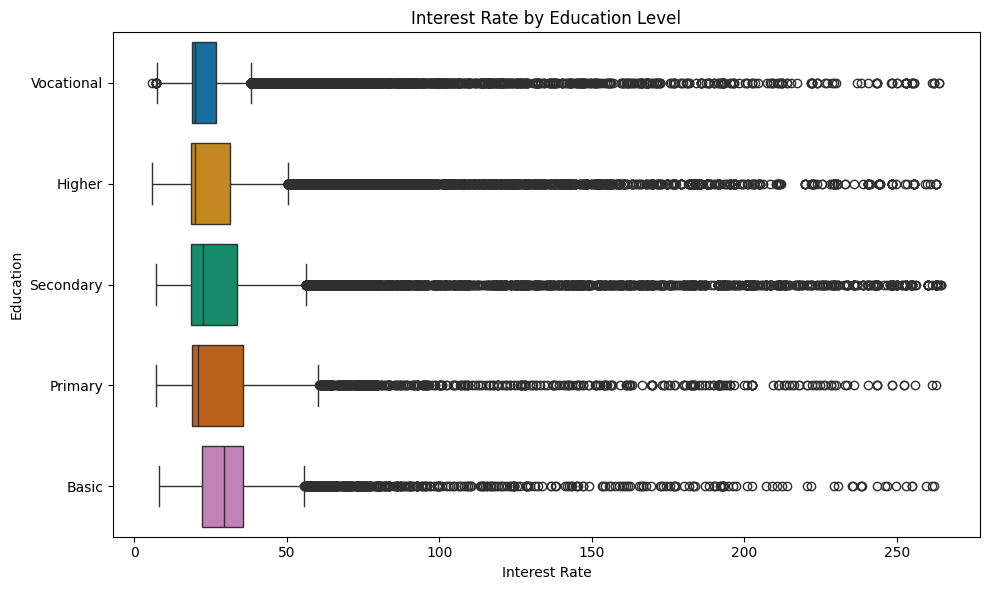

In [9]:

# create the figure with size (10,6)
plt.figure(figsize=(10,6))

# create the interest rate by segmentation plot
boxplot_ax = sns.boxplot(df, x="Interest", y="Education", palette="colorblind")

# set the x-axis label
plt.xlabel("Interest Rate")

# set the title
plt.title("Interest Rate by Education Level")

# despine the plot
sns.despine(top=False, right=False)


plt.tight_layout()
plt.show()

Box plots revealed the influence of borrower education on interest rates, informing potential strategies for segmentation or personalized offers.

<a id="ex5"></a>

#### 6. Correlation and Feature Insights
Using scatterplots and correlations, I explored quantitative relationships between core financial features and interest rate. This formed the basis for subsequent modeling decisions.





Correlation between Interest Rate and LoanDuration:
-0.0106
Correlation between Interest Rate and IncomeTotal:
-0.0122
Correlation between Interest Rate and AmountOfPreviousLoansBeforeLoan:
-0.175
Correlation between Interest Rate and DebtToIncome:
-0.0053


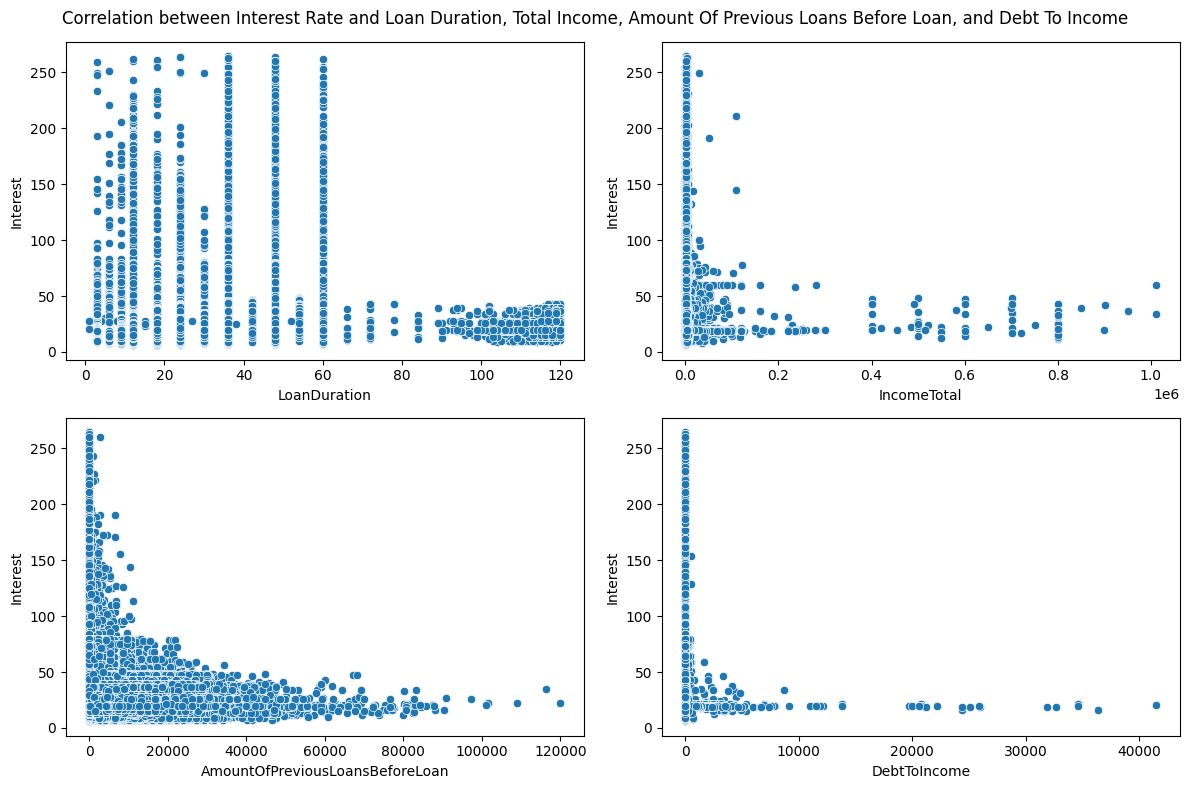

In [10]:


scatterplot_fig = plt.figure(figsize=(12, 8))

# create a list to store the correlation values
correlation = []

# create a list of segmentation columns
corr_columns = ["LoanDuration", "IncomeTotal", "AmountOfPreviousLoansBeforeLoan", 
               "DebtToIncome"]

# iterate over the values 1-4 (one for each subplot)
for i in range(1, 5):

    # get the column name. Remember subtract 1 from i to match the list's indexing
    column_name = corr_columns[i-1]

    # create the subplot. Remember the arguments are (rows, columns, index)
    plt.subplot(2,2,i)

    # create scatter plot
    sns.scatterplot(df, x=df[column_name], y="Interest",
                            )

    # calculate the correlation between the column and the interest rate
    corr = df[corr_columns[i-1]].corr(df["Interest"])

    # append the correlation value to the list
    correlation.append(corr)

    # print the results
    print("Correlation between Interest Rate and " + column_name + ":\n"+ str(round(corr,4))) 

# set the general title
plt.suptitle("Correlation between Interest Rate and Loan Duration, Total Income, Amount Of Previous Loans Before Loan, and Debt To Income")



plt.tight_layout()
plt.show()

This process helped me identify the strongest predictors to use in regression models, maximizing analytical rigor and interpretability.



<a id="applied-and-received-amounts"></a>

### 7. Statistical Inference: Confidence Intervals
I estimated how frequently the loaned amount was below the requested amount by building a 95% confidence interval for this proportion, providing actionable feedback to the business on process consistency.

<a id="ex6"></a>



In [11]:

# get the number of samples where "AppliedAmount" differs from the requested
# "Amount"
num_differences = (df["Amount"] < df["AppliedAmount"]).sum()

# get the total number of samples
n = len(df["Amount"])

# calculate the sample proportion
phat = num_differences / n

# calculate the standard error for proportions
se = sqrt(phat*(1-phat) / n)

# build the confidence interval
confidence_interval = stats.norm.interval(confidence=0.95, loc=phat, scale=se)


In [12]:
# 🔒This cell is locked. You will not be able to edit it.
# print the results
print("The 95% confidence interval is", confidence_interval)

The 95% confidence interval is (np.float64(0.02698232853687249), np.float64(0.028017645379482474))


A tight confidence interval confirmed that underfunding is rare, reinforcing trust in the business process.

 
<a id="step-5"></a>

## 8. Predictive Modeling: Linear and Multiple Regression
As an initial modeling step, I regressed interest rates on the amount of previous loans, examining the predictive power of the single most correlated feature.

a. Simple Linear Regression
<a id="categorical-features"></a>


In [13]:
# prepare predictors. do not forget to add the constant term
X_simple = sm.add_constant(df["AmountOfPreviousLoansBeforeLoan"])

# select the dependent variable
Y_simple = df["Interest"]

# build the model
model_simple = sm.OLS(Y_simple, X_simple)

# fit the model
results_simple = model_simple.fit()

# Print the results summary
print(results_simple.summary())


                            OLS Regression Results                            
Dep. Variable:               Interest   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                 1.211e+04
Date:                Sun, 19 Oct 2025   Prob (F-statistic):               0.00
Time:                        14:52:50   Log-Likelihood:            -1.6468e+06
No. Observations:              383382   AIC:                         3.294e+06
Df Residuals:                  383380   BIC:                         3.294e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

The simple model revealed only limited explanatory power, justifying a more comprehensive approach.

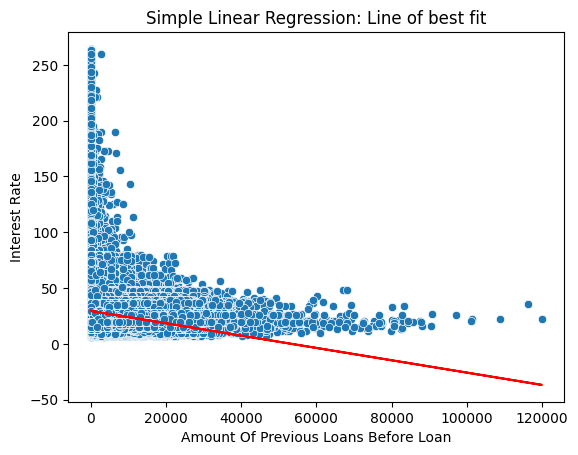

In [14]:
plt.figure()
sns.scatterplot(data=df, x="AmountOfPreviousLoansBeforeLoan", y="Interest")
plt.plot(df["AmountOfPreviousLoansBeforeLoan"], results_simple.predict(X_simple), color="red")
plt.title("Simple Linear Regression: Line of best fit")
plt.xlabel("Amount Of Previous Loans Before Loan")
plt.ylabel("Interest Rate")
plt.show()

In [ ]:
# Checking what columns are numeric
print("Numeric columns:", df.select_dtypes(include="number").columns.tolist())

# Only plot numeric columns
numeric_df = df.select_dtypes(include="number")
sns.pairplot(numeric_df)
plt.show()

Numeric columns: ['Age', 'AppliedAmount', 'Amount', 'Interest', 'LoanDuration', 'IncomeTotal', 'ExistingLiabilities', 'LiabilitiesTotal', 'RefinanceLiabilities', 'NoOfPreviousLoansBeforeLoan', 'AmountOfPreviousLoansBeforeLoan', 'PreviousEarlyRepaymentsCountBeforeLoan', 'DebtToIncome']


In [40]:
df.corr(numeric_only=True)

,NewCreditCustomer,Age,AppliedAmount,Amount,Interest,LoanDuration,IncomeTotal,ExistingLiabilities,LiabilitiesTotal,RefinanceLiabilities,NoOfPreviousLoansBeforeLoan,AmountOfPreviousLoansBeforeLoan,PreviousEarlyRepaymentsCountBeforeLoan,DebtToIncome,IsRisky
NewCreditCustomer,1.000000,-0.055143,0.083922,0.080370,0.193930,-0.097562,0.004466,-0.355763,-0.000762,0.052082,-0.558841,-0.606256,-0.083369,0.006230,0.046308
Age,-0.055143,1.000000,0.090874,0.094767,-0.053237,0.064117,0.020947,0.048082,0.003517,-0.023259,0.022221,0.088478,-0.011864,0.012393,-0.202848
AppliedAmount,0.083922,0.090874,1.000000,0.961652,-0.007984,0.221513,0.017689,-0.126735,-0.000441,0.091856,-0.186792,-0.080203,-0.013472,0.012422,0.037574
Amount,0.080370,0.094767,0.961652,1.000000,-0.036704,0.228230,0.018361,-0.137928,-0.001007,0.090585,-0.182183,-0.071809,-0.017380,0.013463,0.039462
Interest,0.193930,-0.053237,-0.007984,-0.036704,1.000000,-0.010613,-0.012184,-0.115392,0.003885,0.030165,-0.168533,-0.174983,-0.015969,-0.005263,0.037887
LoanDuration,-0.097562,0.064117,0.221513,0.228230,-0.010613,1.000000,0.007785,0.023331,-0.000711,-0.017268,0.094094,0.141992,-0.007472,0.007461,0.009085
IncomeTotal,0.004466,0.020947,0.017689,0.018361,-0.012184,0.007785,1.000000,-0.002411,0.001306,-0.011697,-0.003101,0.008123,-0.004524,-0.003782,-0.024656
ExistingLiabilities,-0.355763,0.048082,-0.126735,-0.137928,-0.115392,0.023331,-0.002411,1.000000,0.011963,0.275383,0.574086,0.398180,0.073882,-0.008418,-0.063258
LiabilitiesTotal,-0.000762,0.003517,-0.000441,-0.001007,0.003885,-0.000711,0.001306,0.011963,1.000000,0.004435,0.001054,0.002330,0.000510,-0.000182,-0.002633
RefinanceLiabilities,0.052082,-0.023259,0.091856,0.090585,0.030165,-0.017268,-0.011697,0.275383,0.004435,1.000000,-0.056886,-0.061561,0.016473,-0.000423,0.015410


In [39]:
df.dtypes

NewCreditCustomer                            bool
LoanDate                                   object
VerificationType                           object
Age                                         int64
Gender                                     object
Country                                    object
AppliedAmount                             float64
Amount                                    float64
Interest                                  float64
LoanDuration                                int64
Education                                  object
EmploymentDurationCurrentEmployer          object
HomeOwnershipType                          object
IncomeTotal                               float64
ExistingLiabilities                         int64
LiabilitiesTotal                          float64
RefinanceLiabilities                        int64
Rating                                     object
NoOfPreviousLoansBeforeLoan               float64
AmountOfPreviousLoansBeforeLoan           float64


<a id="building-the-linear-regression-model"></a>

### b. Multiple Linear Regression

To improve prediction and interpretability, I constructed a multiple regression model leveraging several key borrower and loan features, with categorical variables encoded as needed.



<a id="ex8"></a>


In [41]:
# define a list with the column names you want to use as predictors
# include numerical and categorical variables
predictors = ["NewCreditCustomer", "ExistingLiabilities", "NoOfPreviousLoansBeforeLoan", "AmountOfPreviousLoansBeforeLoan", "Age", "IsRisky", "Education", "Rating"]

categorical = []

# create the predictors dataframe. do not forget to add the constant term
X = sm.add_constant(pd.get_dummies(df[predictors], columns=["NewCreditCustomer", "IsRisky", "Education", "Rating"], drop_first=True, dtype=int))

# create the target variable
Y = df["Interest"]

# create the model
model = sm.OLS(Y, X)

# fit the model
results = model.fit()

### END CODE HERE ###

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               Interest   R-squared:                       0.608
Model:                            OLS   Adj. R-squared:                  0.607
Method:                 Least Squares   F-statistic:                 3.491e+04
Date:                Sun, 19 Oct 2025   Prob (F-statistic):               0.00
Time:                        18:05:01   Log-Likelihood:            -1.4735e+06
No. Observations:              383382   AIC:                         2.947e+06
Df Residuals:                  383364   BIC:                         2.947e+06
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

The final model, with R² > 0.6 and all variables statistically significant, robustly predicts interest rates and highlights the factors most influential in risk-based pricing.




## Skills Demonstrated in this project
**Data Wrangling:** Complex data cleaning, feature engineering, and index management in pandas.

**Statistical Analysis:** Descriptive stats, confidence intervals, hypothesis-driven risk flag creation.

**Data Visualization:** Advanced matplotlib & seaborn charting for both segmentation and relationship discovery.

**Predictive Modeling:** Linear and multiple regression with statistical diagnostics, model selection, and variable encoding.

**Domain Reasoning:** Applied business rules to profile borrower risk, interpret results for actionable policy.

## Conclusion

This project showcases my end-to-end capability in extracting actionable insights from raw financial data, with a clear path from exploration, through business-driven hypothesis creation, to robust predictive modeling.

This portfolio project demonstrates my readiness to analyze, visualize, and model complex datasets for real business impact in a junior data analyst role.